# Getting Dataset Information


Dataset Link : https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import sys
import gc
import time
from tqdm import tqdm  
import shutil

import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array, load_img

In [3]:
### General Helper Functions ### 

# Counts the number of files within the folder
def count_images_in_folders(base_dir: str) -> tuple[int]:
    """
    Counts and prints the number of images in each class folder within the base directory.
    
    Parameters:
        base_dir (str): Path to the main directory containing 'Drowsy' and 'Non Drowsy' folders.
    """
    # Define paths for each class folder
    drowsy_dir = os.path.join(base_dir, "Drowsy")
    non_drowsy_dir = os.path.join(base_dir, "Non Drowsy")
    
    # Count images in each folder
    drowsy_count = len([f for f in os.listdir(drowsy_dir) if os.path.isfile(os.path.join(drowsy_dir, f))])
    non_drowsy_count = len([f for f in os.listdir(non_drowsy_dir) if os.path.isfile(os.path.join(non_drowsy_dir, f))])
    
    # Print the counts
    print(f"Number of preprocessed images in 'Drowsy' folder: {drowsy_count}")
    print(f"Number of preprocessed images in 'Non Drowsy' folder: {non_drowsy_count}")

    return drowsy_count, non_drowsy_count

# Consolidate image paths from a given directory into a list
def consolidate_image_paths(input_path : str, subfolder_name: str = "") -> list[str]:
    return [os.path.join(input_path, subfolder_name, p) for p in os.listdir(os.path.join(input_path, subfolder_name))]

# Map image paths to labels to a dictionary
def map_image_paths_to_labels(image_paths: list[str], label: int) -> dict:
    return {p: label for p in image_paths}

Total Number of Images: 41793
Total Number of Labels: 41793
Difference between Drowsy and Non-Drowsy: 2903


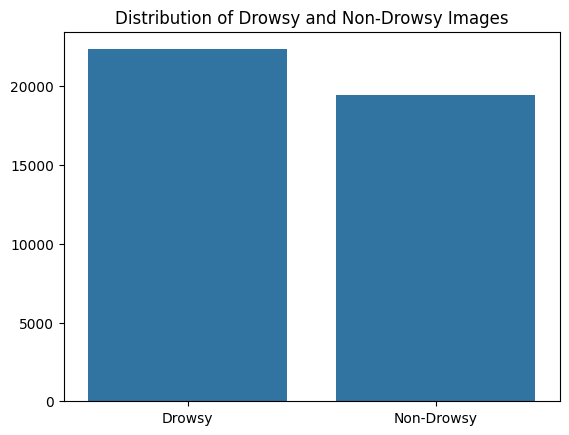

In [4]:
# Base path for the dataset
base_path_2 = "./Datasets/Dataset_2/"
base_path = base_path_2

### Dataset 2 Initialisation ###

# Adds the relative paths of all the images in the dataset
drowsy_paths = consolidate_image_paths(base_path, "Drowsy")
non_drowsy_paths = consolidate_image_paths(base_path, "Non Drowsy")

# Combining all the paths
all_paths = drowsy_paths + non_drowsy_paths

# Mapping the image paths to their respective labels
drowsy_labels = map_image_paths_to_labels(drowsy_paths, 1)
non_drowsy_labels = map_image_paths_to_labels(non_drowsy_paths, 0)

# Combining all the labels
all_labels = [drowsy_labels.get(path, non_drowsy_labels.get(path)) for path in all_paths]

# Verify lengths
print(f"Total Number of Images: {len(all_paths)}")
print(f"Total Number of Labels: {len(all_labels)}")

# Find difference between no. of drowsy and non-drowsy images
print(f"Difference between Drowsy and Non-Drowsy: {len(drowsy_paths) - len(non_drowsy_paths)}")

# Displaying the distribution of drowsy and non-drowsy images
bar_distribution = sns.barplot(x = ["Drowsy", "Non-Drowsy"], y = [len(drowsy_paths), len(non_drowsy_paths)])
plt.title("Distribution of Drowsy and Non-Drowsy Images")
plt.show()

### Insights from Dataset 2

- There are `2903` drowsy images than non-drowsy images.
- The dataset is imbalanced.
- To balance the dataset, we can consider several techniques:
    - Oversampling
    - Undersampling
    - Data Augmentation

# Data Preprocessing

### `Steps`:
1. Image Resizing
2. Data Splitting
3. Reshuffling
4. Undersampling (Majority Class)
5. Data Augmentation (for training data)
6. Data Normalization

### Preprocessing Steps Methodology
1. **Image Resizing**:
    - The images should be resized first to ensure all images are of the same dimensions.
    - The images are resized to `224x224` pixels.

2. **Data Splitting**:
    - Dataset should be split before any form of augmentation or sampling to ensure that the model is evaluated on unseen data.
    - Augmented data can be spilt into the testing and validation sets otherwise.
    - The dataset is split into `70%` training, `15%` validation and `15%` testing sets.

3. **Reshuffling**:
    - The dataset is reshuffled to ensure that the data is not ordered in any way.
    - This helps to prevent the model from learning any patterns in the data that may not be present in real-world scenarios.

4. **Undersampling**:
    - The majority class is undersampled to the number of images in the minority class.

5. **Data Augmentation**:
    - Data Augmentation is applied to the training set only to increase the variability of the training data. 
    - This helps to prevent overfitting and help to contextualise to real-world scenarios. 
    - Possible augmentations are:
        - Rotation
        - Horizontal Flip
        - Vertical Flip
        - Increasing the brightness

6. **Data Normalization**:
    - The pixel values are normalized to the range `[0, 1]` by dividing by `255`.
    

In [5]:
# Step 1: Image Resizing
def resize_image(image: np.ndarray, size: tuple[int, int] = (224, 224)) -> np.ndarray:
    return cv2.resize(image, size)

# Step 2: Data Splitting (applies to paths/labels, not images)
def split_data(X: list[str], y: list[int]) -> tuple[list[str], list[str], list[str], list[int], list[int], list[int]]:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Step 3: Shuffle Image Paths
def shuffle_paths(X_train: list[str], y_train: list[int]) -> tuple[list[tuple[str, int]], list[tuple[str, int]]]:
    drowsy_train = [(path, label) for path, label in zip(X_train, y_train) if label == 1]
    non_drowsy_train = [(path, label) for path, label in zip(X_train, y_train) if label == 0]
    np.random.shuffle(drowsy_train)
    np.random.shuffle(non_drowsy_train)
    return drowsy_train, non_drowsy_train

# Step 4: Undersample Majority Class
def undersample_majority_class(drowsy_data: list[tuple], non_drowsy_data: list[tuple]) -> list[tuple]:
    undersample_size = min(len(drowsy_data), len(non_drowsy_data))
    non_drowsy_data = non_drowsy_data[:undersample_size] if len(non_drowsy_data) > len(drowsy_data) else non_drowsy_data
    drowsy_data = drowsy_data[:undersample_size] if len(drowsy_data) > len(non_drowsy_data) else drowsy_data
    balanced_train = drowsy_data + non_drowsy_data
    np.random.shuffle(balanced_train)
    return balanced_train

# Step 5: Data Augmentation
def augment_image(image: np.ndarray, augment_count: int = 5) -> list[np.ndarray]:
    datagen = ImageDataGenerator(
        rotation_range=15,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        zoom_range=0.1,
        fill_mode='nearest'
    )
    img_array = image.reshape((1,) + image.shape)
    augmented_images = [next(datagen.flow(img_array, batch_size=1))[0].astype(np.float32) for _ in range(augment_count)]
    return augmented_images

# Step 6: Data Normalization
def normalize_image(image: np.ndarray) -> np.ndarray:
    return image / 255.0

# Main Pipeline Function with Saving Step
def preprocess_pipeline(image_paths: list[str], labels: list[int], augment_count: int = 5, save_dir: str = "Preprocessed_Images", batch_size: int = 100):
    """
    Sequentially applies resizing, undersampling, augmentation, and normalization to images in batches,
    and saves the final preprocessed images to the specified directory.
    
    Parameters:
        image_paths (list): List of image paths.
        labels (list): Corresponding list of labels for each image.
        augment_count (int): Number of augmented images to generate per original image.
        save_dir (str): Directory to save processed images.
        batch_size (int): Number of images to process per batch.
    """
    os.makedirs(os.path.join(save_dir, "Drowsy"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "Non Drowsy"), exist_ok=True)

    # Loop through the dataset in batches
    for start in tqdm(range(0, len(image_paths), batch_size), desc="Processing Batches"):
        end = min(start + batch_size, len(image_paths))
        batch_paths = image_paths[start:end]
        batch_labels = labels[start:end]

        for img_path, label in zip(batch_paths, batch_labels):
            # Load image and convert to RGB format
            img = cv2.imread(img_path)
            if img is None:
                print(f"Skipping invalid image: {img_path}")
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize the image
            resized_image = resize_image(img_rgb)

            # Apply augmentation and normalization
            augmented_images = augment_image(resized_image, augment_count=augment_count)
            for idx, aug_img in enumerate(augmented_images):
                normalized_img = normalize_image(aug_img)
                class_name = "Drowsy" if label == 1 else "Non Drowsy"

                # Convert back to BGR before saving to maintain correct color in saved image
                save_img = cv2.cvtColor((normalized_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                save_filename = f"{class_name}_{start + idx}_{idx}.jpg"
                save_path = os.path.join(save_dir, class_name, save_filename)
                cv2.imwrite(save_path, save_img)

        # Clear memory after each batch
        gc.collect()

    print("Processing complete.")

In [7]:
output_folder_path = os.path.join(base_path, "Preprocessed_Images")

In [6]:
# processed_data = preprocess_pipeline(all_paths, all_labels, augment_count=5, save_dir=output_folder_path)

Processing Batches: 100%|██████████| 418/418 [33:51<00:00,  4.86s/it]

Processing complete.


In [8]:
# Verify total number of processed images in training data

print("Unprocessed Total Images:")
unprocessed_drowsy, unprocessed_non_drowsy = count_images_in_folders(base_path)
print(f"\nUnprocessed Training Images:")
print(f"Number of preprocessed images in 'Drowsy' folder: {round(unprocessed_drowsy * 0.7)}")
print(f"Number of preprocessed images in 'Non Drowsy' folder: {round(unprocessed_non_drowsy * 0.7)}\n")
print("Processed Images Folder:")
count_images_in_folders(output_folder_path) 

Unprocessed Total Images:
Number of preprocessed images in 'Drowsy' folder: 22348
Number of preprocessed images in 'Non Drowsy' folder: 19445

Unprocessed Training Images:
Number of preprocessed images in 'Drowsy' folder: 15644
Number of preprocessed images in 'Non Drowsy' folder: 13612

Processed Images Folder:
Number of preprocessed images in 'Drowsy' folder: 86195
Number of preprocessed images in 'Non Drowsy' folder: 975


(86195, 975)